![](img/banner.png)
%%HTML
<script src="require.js"></script>

# Bias-Variance Tradeoff

**Mahmood Amintoosi, Fall 2024**

Computer Science Dept, Ferdowsi University of Mashhad

* [Wiki: Bias variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)
* [MLU-Explain bias-variance](https://mlu-explain.github.io/bias-variance/)

**Further Reading**

* [MLU-Explain double-descent, part 1](https://mlu-explain.github.io/double-descent/)
* [MLU-Explain double-descent, part 2](https://mlu-explain.github.io/double-descent2/)
* [The Bias-Variance Tradeoff: A Newbie’s Guide, by a Newbie](https://medium.com/@DeepthiTabithaBennet/the-bias-variance-tradeoff-a-newbies-guide-by-a-newbie-95fb03dbebcb)
* [bias-variance-trade-off](https://spotintelligence.com/2023/04/11/bias-variance-trade-off/)

* Paper: [VC Theoretical Explanation of Double Descent](https://arxiv.org/abs/2205.15549)

* Paper: [Reconciling modern machine-learning practice and the classical bias–variance trade-off](https://www.pnas.org/doi/10.1073/pnas.1903070116)
  - [Double Descent](https://medium.com/mlearning-ai/double-descent-8f92dfdc442f), [Highlights](misc/medium-com_mlearning-ai_double-descent-highlightes.md)
  - [Reproducing Deep Double Descent](https://hippocampus-garden.com/double_descent/), [Highlights](misc/hippocampus-garden-com_double_descent-highlightes.md)
    + [deep_double_descent, colab](https://colab.research.google.com/drive/1lT2dUqal90NbLVQIGvseyAdKzH19MH2T?usp=sharing)
* [Sec 22.3 of Zaki](https://fumdrive.um.ac.ir/index.php/f/4160875)

* Paper: [Understanding the double descent curve in Machine Learning](https://arxiv.org/abs/2211.10322)


In [1]:
import numpy as np
from numpy import polyfit
from numpy import polyval
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def f(x):
    return np.sin(x * np.pi)

In [3]:
def error_function(pred, actual):
    return (pred - actual) ** 2

In [4]:
np.random.seed(120)
n_observations_per_dataset = 25
n_datasets = 1000
max_poly_degree = 12  # Maximum model complexity
model_poly_degrees = range(1, max_poly_degree + 1)

In [5]:
NOISE_STD = .5
percent_train = .8
n_train = int(np.ceil(n_observations_per_dataset * percent_train))

In [6]:
x = np.linspace(-1, 1, n_observations_per_dataset)
x = np.random.permutation(x)
x_train = x[:n_train]
x_test = x[n_train:]

In [7]:
theta_hat = defaultdict(list)

pred_train = defaultdict(list)
pred_test = defaultdict(list)

train_errors = defaultdict(list)
test_errors = defaultdict(list)

In [8]:
for dataset in range(n_datasets):

    # Simulate training/testing targets
    y_train = f(x_train) + NOISE_STD * np.random.randn(*x_train.shape)
    y_test = f(x_test) + NOISE_STD * np.random.randn(*x_test.shape)

    # Loop over model complexities
    for degree in model_poly_degrees:
        
        # Train model
        tmp_theta_hat = polyfit(x_train, y_train, degree)

        # Make predictions on train set
        tmp_pred_train = polyval(tmp_theta_hat, x_train)
        pred_train[degree].append(tmp_pred_train)

        # Test predictions
        tmp_pred_test = polyval(tmp_theta_hat, x_test)
        pred_test[degree].append(tmp_pred_test)

        # Mean Squared Error for train and test sets
        train_errors[degree].append(np.mean(error_function(tmp_pred_train, y_train)))
        test_errors[degree].append(np.mean(error_function(tmp_pred_test, y_test)))

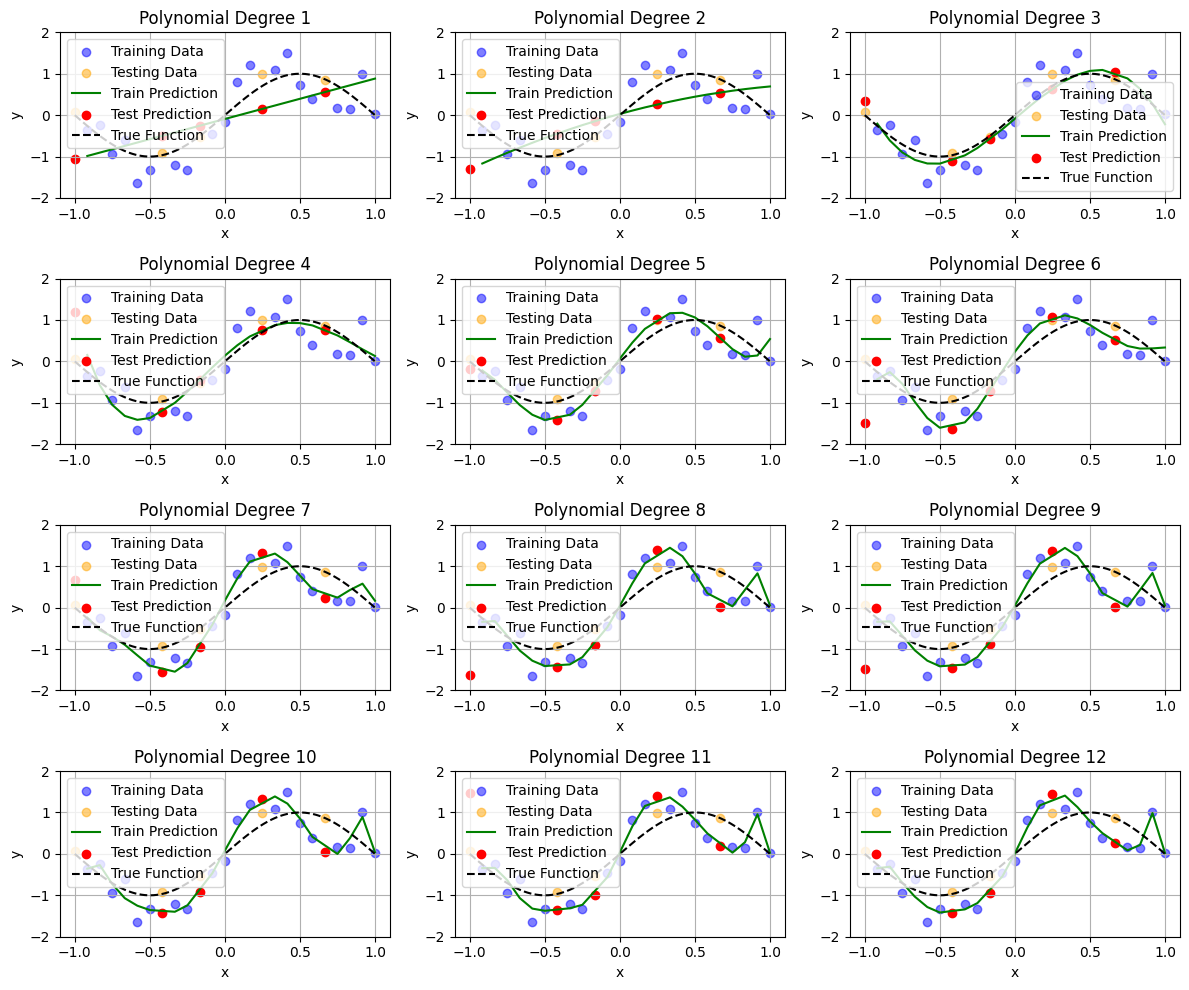

In [9]:
# Visualization
plt.figure(figsize=(12, 10))

# Loop through each model complexity for visualization
for degree in model_poly_degrees:
    plt.subplot(4, 3, model_poly_degrees.index(degree) + 1)
    
    # Plot training data
    plt.scatter(x_train, y_train, color='blue', label='Training Data', alpha=0.5)
    plt.scatter(x_test, y_test, color='orange', label='Testing Data', alpha=0.5)

    # Plot predictions for the last dataset
    # Sort the data for plotting
    sorted_indices_train = np.argsort(x_train)

    # Plot predictions for the last dataset using sorted data
    plt.plot(x_train[sorted_indices_train], pred_train[degree][-1][sorted_indices_train], label='Train Prediction', color='green')
    plt.scatter(x_test, pred_test[degree][-1], label='Test Prediction', color='red')

    # Plot the true function
    x_fine = np.linspace(-1, 1, 100)
    plt.plot(x_fine, f(x_fine), 'k--', label='True Function')

    plt.title(f'Polynomial Degree {degree}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-2, 2])
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [10]:
def calculate_estimator_bias_squared(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)

    return np.mean((average_model_prediction - f(x_test)) ** 2)

In [11]:
def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)
    
    return np.mean((pred_test - average_model_prediction) ** 2)

In [12]:
complexity_train_error = []
complexity_test_error = []
bias_squared = []
variance = []
for degree in model_poly_degrees:
    complexity_train_error.append(np.mean(train_errors[degree]))
    complexity_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))

best_model_degree = model_poly_degrees[np.argmin(complexity_test_error)]

Text(0.5, 1.0, 'Bias-Variance Tradeoff')

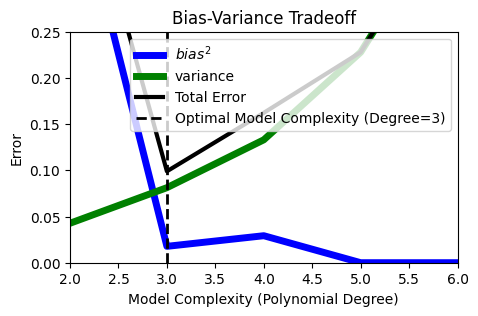

In [13]:

plt.figure(figsize=(5, 3))
plt.plot(model_poly_degrees, bias_squared, color='blue', label='$bias^2$', linewidth=5)
plt.plot(model_poly_degrees, variance, color='green', label='variance', linewidth=5)
plt.plot(model_poly_degrees, np.array(bias_squared) + np.array(variance), linewidth=3, color='black', label='Total Error')
plt.axvline(best_model_degree, color='black', linestyle='--', linewidth=2, label=f'Optimal Model Complexity (Degree={best_model_degree})')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('Error')
plt.ylim([0, .25])
plt.xlim([2, 6])
plt.legend()
plt.title('Bias-Variance Tradeoff')

In [ ]:
# # https://spotintelligence.com/2023/04/11/bias-variance-trade-off/
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate some synthetic data with a non-linear relationship
# np.random.seed(0)
# x = np.linspace(-5, 5, num=100)
# # y = x ** 3 + np.random.normal(size=100)
# y = f(x) #np.sin(x * np.pi)

# # Split the data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# # Fit polynomial regression models with different degrees of polynomials
# degrees = [1, 2, 3, 4, 5, 8, 10]
# train_errors, test_errors = [], []
# bias_squared = []
# variance = []

# for degree in degrees:

#     # Transform the features to polynomial features
#     poly_features = PolynomialFeatures(degree=degree)
#     x_poly_train = poly_features.fit_transform(x_train.reshape(-1, 1))
#     x_poly_test = poly_features.transform(x_test.reshape(-1, 1))

#     # Fit the linear regression model to the polynomial features
#     model = LinearRegression()
#     model.fit(x_poly_train, y_train)

#     # Evaluate the model on the training and testing data
#     y_pred_train = model.predict(x_poly_train)
#     y_pred_test = model.predict(x_poly_test)
#     train_error = mean_squared_error(y_train, y_pred_train)
#     test_error = mean_squared_error(y_test, y_pred_test)
#     train_errors.append(train_error)
#     test_errors.append(test_error)
#     bias_squared.append(calculate_estimator_bias_squared(y_pred_test))
#     variance.append(calculate_estimator_variance(y_pred_test))


# # Plot the training and testing errors as a function of the degree of polynomial

# plt.plot(degrees, train_errors, label='Training error')
# plt.plot(degrees, test_errors, label='Testing error')
# plt.plot(degrees, bias_squared, color='blue', label='$bias^2$', linewidth=5)
# plt.plot(degrees, variance, color='green', label='variance', linewidth=5)

# plt.legend()
# plt.xlabel('Degree of polynomial')
# plt.ylabel('Mean squared error')
# plt.show()
